In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append("../src")

from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
c_folder="../../data/calibration/"
d_folder="../../data/runData/"
r_n=307
p_folder="../../plots/run_"+str(r_n)+"/"

In [7]:
%%time
p,m,r=import_data(c_folder,d_folder, 305, is_it_pulsed=False)

CPU times: user 7.75 s, sys: 629 ms, total: 8.38 s
Wall time: 8.95 s


In [8]:
%%time
r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=False) #this needs to be run as it's own cell

Number of events: 47351


Initial pedestal-based selection performed.
Events left: 46271


CPU times: user 970 ms, sys: 161 ms, total: 1.13 s
Wall time: 1.13 s


In [64]:
def longitudinal_profile(run_df, run_number, plot_folder, save_plot=True):
    n_event=len(run_df.pf_event.unique())
    layer_sum=run_df.groupby(["layer"]).sum()[["adc_sum_end0", "adc_sum_end1"]]/n_event

    plt.bar(layer_sum.index-0.2, layer_sum["adc_sum_end0"], color="magenta", alpha=0.5, edgecolor="magenta", label="end_0", width=0.4)
    plt.bar(layer_sum.index+0.2, layer_sum["adc_sum_end1"], color="blue", alpha=0.5, edgecolor="blue", label="end_1", width=0.4)
    plt.xlim(0.5,19.5)
    plt.xticks(np.arange(1,20))
    plt.legend()
    plt.xlabel("Layer", fontsize=12.5)
    plt.ylabel("Reconstructed energy [MeV]", fontsize=12.5)
    plt.title("Run "+str(run_number), fontsize=15)
    
    if save_plot==True:
        plt.savefig(plot_folder+"longitudinal_profile.png", bbox_inches='tight')
        
    plt.show()

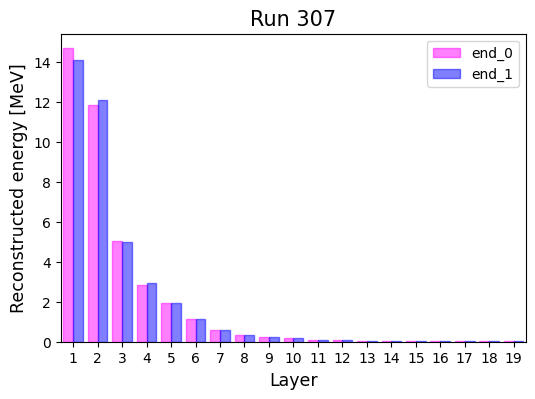

In [65]:
longitudinal_profile(r,r_n,p_folder, save_plot=False)

In [11]:
r=convert_mip_to_MeV(r, m, is_it_pulsed=False)
r.head()

,pf_event,tot_end0,adc_sum_end0,adc_mean_end0,adc_max_end0,layer,strip,tot_end1,adc_sum_end1,adc_mean_end1,adc_max_end1
0,15,0,5.902279,0.737785,1.167117,1,0,0,3.508247,0.438531,0.637863
1,247,0,1.011502,0.126438,0.200077,1,0,0,1.209740,0.151218,0.263943
2,257,0,8.525515,1.065689,1.778465,1,0,0,6.521600,0.815200,1.649646
3,265,0,11.204327,1.400541,2.245312,1,0,0,11.393555,1.424194,2.199528
4,289,0,10.592980,1.324122,2.078581,1,0,0,10.271795,1.283974,1.957580


In [78]:
n_event=len(r.pf_event.unique())
layer_sum=r.groupby(["layer"]).sum()[["adc_sum_end0", "adc_sum_end1"]]/n_event

In [82]:
strip_sum=r.groupby(["layer", "strip"]).sum()[["adc_sum_end0", "adc_sum_end1"]]/n_event

In [109]:
strip_sum[["adc_sum_end0", "adc_sum_end1"]].max(axis=0)

adc_sum_end0    5.534388
adc_sum_end1    5.143672
dtype: float64

In [86]:
# for i in range(1,20):
#    strip_sum[strip_sum["layer"]==i]

ConversionError: Failed to convert value(s) to axis units: 'adc_sum_end1'

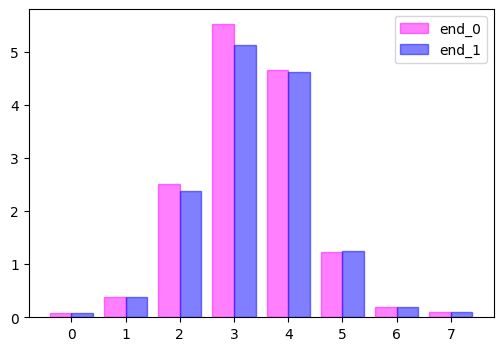

In [99]:
helper_df=strip_sum.xs(1, level=0, axis=0, drop_level=True)
plt.bar(helper_df.index-0.2, helper_df["adc_sum_end0"], color="magenta", alpha=0.5, edgecolor="magenta", label="end_0", width=0.4)
plt.bar(helper_df.index+0.2, helper_df["adc_sum_end1"], color="blue", alpha=0.5, edgecolor="blue", label="end_1", width=0.4)
plt.legend()
plt.xticks(helper_df.index)
plt.ylim(0,max(strip_sum))
plt.show()

In [ ]:
#def make_shower_profiles(run_df, mip_df):
#    run_df=convert_mip_to_MeV(run_df, mip_df, is_it_pulsed=False)
    


In [10]:
r.head()

,pf_event,tot_end0,adc_sum_end0,adc_mean_end0,adc_max_end0,layer,strip,tot_end1,adc_sum_end1,adc_mean_end1,adc_max_end1,pedestal_per_time_sample_std_dev_end0,pedestal_per_time_sample_std_dev_end1
15,15,0,531,66.375,105,1,0,0,319,39.875,58,1.1587,1.67444
247,247,0,91,11.375,18,1,0,0,110,13.750,24,1.1587,1.67444
257,257,0,767,95.875,160,1,0,0,593,74.125,150,1.1587,1.67444
265,265,0,1008,126.000,202,1,0,0,1036,129.500,200,1.1587,1.67444
289,289,0,953,119.125,187,1,0,0,934,116.750,178,1.1587,1.67444


In [9]:
# %%time
# pulses=make_pulse_profiles(r)
# pulses.to_csv(d_folder+"/run_"+str(r_n)+"_pulse_problems.csv")